<a href="https://colab.research.google.com/github/hpazerf/web-scraper/blob/main/Web_Scraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup 

In [1]:
 # Use this code if using Colab to run Selenium

# Make sure to go to Runtime -> Change runtime type and select Python 3 as runtime type and GPU as hardware accelerator

# !kill -9 -1 # Use this line to delete this VM and start a new one. 
# The above line deletes all files and folders from the current VM and allocates a new one.

!pip install selenium
!pip install nltk
!apt-get -q update # to update ubuntu to correctly run apt install
!apt install -yq chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

     |████████████████████████████████| 911kB 4.5MB/s 
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [40.1 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates In

Test to see if selenium is working properly

In [2]:

#wd = webdriver.Chrome('chromedriver',options=chrome_options)
#wd.get("https://www.website.com")
#print(wd.page_source)  # results

In [3]:
import pandas as pd
from datetime import datetime
import numpy as np
import io
import re
import string
import nltk
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler

##SCRAPING DATA SECTION


We scraped the data from [https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans](https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans).

We grabbed the oldest comments, about 5,500, from 110 pages.

In [4]:
# Creating a dataframe to place information into
comments = pd.DataFrame(columns = ['Date','user_id','comments']) 
url = []
# 455 pages possible
# 50 comments per page
# 110 pages gives 5500 comments
for page in range(1,111):
  string = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p'+str(page)
  url.append(string)

In [ ]:
# A loop to extract all the comments in each link
for page in range(0,len(url)):
  driver = webdriver.Chrome('chromedriver',options=chrome_options)
  driver.get(url[page])
  ids = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]")
  comment_ids = []
  for i in ids:
      comment_ids.append(i.get_attribute('id'))
  for x in comment_ids:
      #Extract dates from for each user on a page
      user_date = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
      date = user_date.get_attribute('title')

      #Extract user ids from each user on a page
      userid_element = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
      userid = userid_element.text

      #Extract Message for each user on a page
      user_message = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[3]/div/div[1]')[0]
      comment = user_message.text
                                    
      #Adding date, userid and comment for each user in a dataframe    
      comments.loc[len(comments)] = [date,userid,comment]

In [ ]:
# Turning the scraped data into a csv file for ease of future use
comments.to_csv("comments.csv")

## UPLOADING AND SETTING UP DATA

In [9]:
comments = pd.read_csv('comments.csv',index_col=0)

In [10]:
##Change file name to "change_car models and brands.csv"
df_brands = pd.read_csv('changed_car models and brands.csv',header=None)

In [11]:
# Places all the brand names into a list to check word frequency through comments
brands=df_brands[1].unique()
brands

array(['acura', 'audi', 'bmw', 'buick', 'cadillac', 'chevrolet',
       'chrysler', 'dodge', 'ford', 'honda', 'hyundai kia', 'hyundai',
       'infiniti', 'kia', 'lincoln', 'mazda', 'mercedes', 'mercedes benz',
       'mercedes-benz', 'mercury', 'mitsubishi', 'nissan', 'pontiac',
       'saturn', 'subaru', 'suzuki', 'toyata', 'toyota', 'volkswagen',
       'volvo', 'lexus'], dtype=object)

In [12]:
# Looking through all the comments in the comment dataframe
# and counting all the times a type of brand was mentioned by a user
# Checking to make sure comments actually exist
# Comment 223 is empty
count_dict ={}
for brand in brands:
  for i in range((comments.shape[0])):
    if type(comments.loc[i,'comments']) == str:
      user_comment=comments.loc[i,'comments'].lower()
      if (brand.lower() in user_comment):
        if brand not in count_dict:
          count_dict[brand] = 1
        else:
            count_dict[brand] += 1

In [13]:
# Making the dictionary into a dataframe adn sorting to get the highest 10 brands mentioned
count_df = pd.DataFrame.from_dict(count_dict, orient='index', columns=['Frequency'])
#This is before the models have been replaced with the brand
count_df.sort_values(by=['Frequency'], ascending=False).head(10)

,Frequency
bmw,1399
acura,482
lexus,452
infiniti,411
audi,380
honda,218
nissan,215
ford,187
mercedes,176
toyota,148


In [14]:
# Converting the dataframe into a csv file for future use
#count_df.to_csv("brand_count.csv")

## TASK A: Find the Lift Ratios between each brand

In [15]:
# Replacing all the model names into brand names
replaced_df = comments.copy()
for i in range((df_brands.shape[0])):
  replacee=df_brands.loc[i,0].lower()
  #replacee = '\b'+replacee+'\b'
  replacedby=df_brands.loc[i,1].lower()
  #replacedby='\b'+replacedby+'\b'
  replaced_df["comments"]= replaced_df["comments"].str.replace(rf"\b{replacee}\b", replacedby, case = False)


In [16]:
# Looking through all the comments after the model names have been replaced by the brand names
replaced_count_dict ={}
for brand in brands:
  for i in range((replaced_df.shape[0])):
    if type(replaced_df.loc[i,'comments']) == str: 
      user_comment=replaced_df.loc[i,'comments'].lower()
      if (brand.lower() in user_comment):
        if brand not in replaced_count_dict:
          replaced_count_dict[brand] = 1
        else:
          replaced_count_dict[brand] += 1

In [17]:
# Making the dictionary into a dataframe
replaced_count_df = pd.DataFrame.from_dict(replaced_count_dict, orient='index', columns=['Frequency'])
print("The top ten brands are: ")
replaced_count_df.sort_values(by=['Frequency'], ascending=False).head(10)

The top ten brands are: 


,Frequency
bmw,1640
acura,653
audi,549
honda,481
infiniti,477
lexus,465
nissan,335
ford,265
toyota,256
mercedes,250


In [18]:
replaced_count_df.to_csv("replaced_count.csv")

In [19]:
# Converting the top ten brands to a list for manipulation
top_ten_brands=replaced_count_df.sort_values(by=['Frequency'], ascending=False).head(10).index.to_list()

In [20]:
# Creating a list that creates the pairs two brands name to find the frequency when both are mentioned at the same time in a comment
# car bmw
# car toyota
# car acura

i= 0
lift_dict={}
used_list=[]
for name1 in top_ten_brands:
  for name2 in top_ten_brands:
    # you want the lift ratios not to repeat use this if statment and place the code below the if statement
    #if (name1 != name2) and (name2 not in used_list):
    i+=1
    lift_dict[i] = []
    lift_dict[i].append(name1)
    lift_dict[i].append(name2)
  used_list.append(name1)

name1=[]
name2=[]
frequency=[]
for pair in lift_dict.values():
    name1.append(pair[0])
    name2.append(pair[1])
    frequency.append(0)

for i in range(len(name1)):
    for j in range((replaced_df.shape[0])):
      if type(replaced_df.loc[j,'comments']) == str: 
        user_comment=replaced_df.loc[j,'comments'].lower()
        if ((name1[i].lower() in user_comment) and (name2[i].lower() in user_comment)):
          num=frequency[i]+1
          frequency[i]=num

In [21]:
# Creating a dataframe of the information
pair_freq_df= pd.DataFrame(name1, columns = ['Name1'])
pair_freq_df["Name2"]=name2
pair_freq_df["Frequency"]=frequency

In [22]:
# Finding the lift ratio for each pair
samples = comments.shape[0]
lift_ratio_list = []
for i in range((pair_freq_df.shape[0])):
  pair_freq = pair_freq_df.loc[i,'Frequency']
  brand1 = pair_freq_df.loc[i,'Name1']
  brand2 = pair_freq_df.loc[i,'Name2']
  #A_freq = top_ten_dict.get(brand1)
  A_freq = replaced_count_df.loc[brand1].to_numpy()[0]
  #B_freq = top_ten_dict.get(brand2)
  B_freq = replaced_count_df.loc[brand2].to_numpy()[0]
  lift_ratio = (samples*pair_freq)/(A_freq*B_freq)
  lift_ratio_list.append(lift_ratio)

In [23]:
# Creating a dataframe that shows the two brand names and their lift ratio
lift_ratio_df= pd.DataFrame(name1, columns = ['Brand 1'])
lift_ratio_df["Brand 2"]=name2
lift_ratio_df["Lift Ratio"]=lift_ratio_list

In [24]:
lift_ratio_df.to_csv("lift_ratio.csv")

In [25]:
# all_lift_ratios = pd.read_csv('lift_ratio_with_allvalue.csv', index_col=0)
all_lift_ratios = lift_ratio_df
sim_matrix = all_lift_ratios.pivot(index='Brand 1', columns='Brand 2', values='Lift Ratio')
np.fill_diagonal(sim_matrix.to_numpy(), None)
# Dissimilarity matrix
dis_matrix = 1/sim_matrix
np.fill_diagonal(dis_matrix.to_numpy(), 0)
print("Lift Calculations for brands: ")
sim_matrix

Lift Calculations for brands: 


Brand 2,acura,audi,bmw,ford,honda,infiniti,lexus,mercedes,nissan,toyota
Brand 1,,,,,,,,,,
acura,NaN,2.147856,1.494509,1.589182,2.749186,3.019446,2.952461,2.088821,2.287948,1.710854
audi,2.147856,NaN,1.753188,1.814620,1.312157,2.352285,2.412989,3.285974,1.315825,0.978341
bmw,1.494509,1.753188,NaN,1.468017,1.185285,1.884236,2.055468,1.837805,1.191300,1.362424
ford,1.589182,1.814620,1.468017,NaN,2.157455,1.566394,1.919253,2.324528,1.672768,1.864682
honda,2.749186,1.312157,1.185285,2.157455,NaN,1.486247,1.450830,1.600832,3.754616,3.439287
infiniti,3.019446,2.352285,1.884236,1.566394,1.486247,NaN,3.620297,2.306080,2.891204,0.990894
lexus,2.952461,2.412989,2.055468,1.919253,1.450830,3.620297,NaN,3.926882,1.447601,2.171539
mercedes,2.088821,3.285974,1.837805,2.324528,1.600832,2.306080,3.926882,NaN,1.576119,1.976562
nissan,2.287948,1.315825,1.191300,1.672768,3.754616,2.891204,1.447601,1.576119,NaN,2.821828


MDS Map


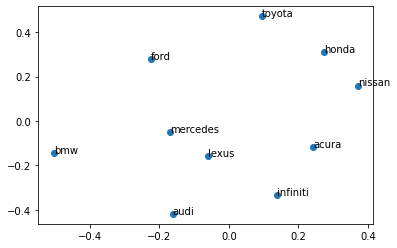

In [26]:
mds = MDS(2,random_state=0,dissimilarity='precomputed')
dis_sim_2d_matrix = mds.fit_transform(dis_matrix) ##computes distances
data = pd.DataFrame(dis_sim_2d_matrix, columns=['x', 'y'], index = dis_matrix.index)
plt.scatter(data.x, data.y)
ax = plt.gca()

print("MDS Map")
for index, x_val, y_val in data.itertuples():
    ax.annotate(index, (x_val, y_val))

# TASK B: Finding common attributes about cars and comparing them to the brands


## List of Word Frequency

In [34]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [35]:
# Count Word Frequency
word_freq = {}
for i in range((comments.shape[0])):
  if type(replaced_df.loc[i,'comments']) == str: 
    user_comment=replaced_df.loc[i,'comments'].lower()
    match_pattern = re.findall(r'\b[a-z]{3,15}\b', user_comment)
    for word in match_pattern:
      if word not in stop_words:
        count = word_freq.get(word,0)
        word_freq[word] = count + 1

In [36]:
word_freq_df = pd.DataFrame.from_dict(word_freq, orient='index', columns=['Frequency'])
#word_freq_df.sort_values(by=['Frequency'], ascending=False).head(10)

In [37]:
sorted=word_freq_df.sort_values(by=['Frequency'], ascending=False)

In [38]:
word_freq_df.to_csv("word_freq.csv")

In [39]:
sorted.to_csv("sorted_word_freq.csv")

## Counting Attributes

In [40]:
attributes=['performance', 'luxury', 'interior', 'power', 'speed', 
            'reliability', 'pretty', 'quality', 'mpg', 'size', 'acceleration', 
            'suspension', 'design', 'service', 'exterior', 
            'reliable', 'space', 'maintenance', 'powerful', 
            'convertible', 'comfortable', 'racing', 'prestige' ]

In [41]:
# Looking through all the comments after the model names have been replaced by the brand names
attributes_count_dict ={}
for attribute in attributes:
  for i in range((replaced_df.shape[0])):
    if type(replaced_df.loc[i,'comments']) == str: 
      user_comment=replaced_df.loc[i,'comments'].lower()
      if (attribute.lower() in user_comment):
        if attribute not in attributes_count_dict:
          attributes_count_dict[attribute] = 1
        else:
          attributes_count_dict[attribute] += 1

In [42]:
# Making the dictionary into a dataframe
attributes_count_df = pd.DataFrame.from_dict(attributes_count_dict, orient='index', columns=['Frequency'])
print("Top 5 attributes: ")
attributes_count_df.sort_values(by=['Frequency'], ascending=False).head(5)

Top 5 attributes: 


,Frequency
performance,743
power,626
luxury,541
speed,459
interior,419


In [43]:
top_five_attributes=attributes_count_df.sort_values(by=['Frequency'], ascending=False).head(5).index.to_list()

In [44]:
top_five_brands=replaced_count_df.sort_values(by=['Frequency'], ascending=False).head(5).index.to_list()

In [45]:
# Creating a list that creates the pairs a brand with an atrribute name to find the frequency when both are mentioned at the same time in a comment
# performance bmw
# performance toyota
# performance acura

i= 0
#count= 0
ba_lift_dict={}
ba_used_list=[]
for name1 in top_five_brands:
  #count+=1
  #print(count)
  for name2 in top_five_attributes:
    # you want the 
    #if (name1 != name2) and (name2 not in used_list):
    i+=1
    #print(str(count)+'-'+str(i))
    ba_lift_dict[i] = []
    ba_lift_dict[i].append(name1)
    ba_lift_dict[i].append(name2)
  ba_used_list.append(name1)

pair_brand=[]
pair_attribute=[]
ba_freq=[]
for pair in ba_lift_dict.values():
    pair_brand.append(pair[0])
    pair_attribute.append(pair[1])
    ba_freq.append(0)

for i in range(len(pair_brand)):
    for j in range((replaced_df.shape[0])):
      if type(replaced_df.loc[j,'comments']) == str: 
        user_comment=replaced_df.loc[j,'comments'].lower()
        if ((pair_brand[i].lower() in user_comment) and (pair_attribute[i].lower() in user_comment)):
          num=ba_freq[i]+1
          ba_freq[i]=num

In [46]:
# Creating a dataframe of the information
ba_pair_freq_df= pd.DataFrame(pair_brand, columns = ['Brand'])
ba_pair_freq_df["Attribute"]=pair_attribute
ba_pair_freq_df["Frequency"]=ba_freq

In [47]:
# Finding the lift ratio for each pair
samples = comments.shape[0]
ba_lift_ratio_list = []
for i in range((ba_pair_freq_df.shape[0])):
  pair_freq = ba_pair_freq_df.loc[i,'Frequency']
  brand_pair = ba_pair_freq_df.loc[i,'Brand']
  attribute_pair = ba_pair_freq_df.loc[i,'Attribute']
  A_freq = replaced_count_df.loc[brand_pair].to_numpy()[0]
  B_freq = attributes_count_df.loc[attribute_pair].to_numpy()[0]
  ba_lift_ratio = (samples*pair_freq)/(A_freq*B_freq)
  ba_lift_ratio_list.append(ba_lift_ratio)

In [48]:
# Creating a dataframe that shows the two brand names and their lift ratio
ba_lift_ratio_df= pd.DataFrame(pair_brand, columns = ['Brand'])
ba_lift_ratio_df["Attribute"]=pair_attribute
ba_lift_ratio_df["Lift Ratio"]=ba_lift_ratio_list

In [49]:
ba_lift_ratio_df

,Brand,Attribute,Lift Ratio
0,bmw,performance,1.503053
1,bmw,power,1.542897
2,bmw,luxury,1.450566
3,bmw,speed,1.271322
4,bmw,interior,1.360673
5,acura,performance,1.439675
6,acura,power,1.802935
7,acura,luxury,1.961656
8,acura,speed,1.578103
9,acura,interior,1.668451


The top five attibutes are: performance power, luxury, speed and iterior

In [50]:
#For each brand, we sort the attributes by lift ratio in descending order
ba_lift_ratio_df.groupby('Brand').apply(lambda x: x.sort_values(by='Lift Ratio', ascending=False))

Brand    Attribute  Lift Ratio
Brand                                         
acura    7      acura       luxury    1.961656
         6      acura        power    1.802935
         9      acura     interior    1.668451
         8      acura        speed    1.578103
         5      acura  performance    1.439675
audi     14      audi     interior    2.367072
         11      audi        power    1.856410
         12      audi       luxury    1.666616
         13      audi        speed    1.506006
         10      audi  performance    1.334863
bmw      1        bmw        power    1.542897
         0        bmw  performance    1.503053
         2        bmw       luxury    1.450566
         4        bmw     interior    1.360673
         3        bmw        speed    1.271322
honda    17     honda       luxury    1.859957
         16     honda        power    1.826599
         15     honda  performance    1.446627
         18     honda        speed    1.444884
         19     honda     interior    1.337210
infiniti 24  infiniti     interior    1.981357
         22  infiniti       luxury    1.662423
         20  infiniti  performance    1.458758
         21  infiniti        power    1.418276
         23  infiniti        speed    1.205793

In [51]:
grouped = ba_lift_ratio_df.groupby('Brand').apply(lambda x: x.sort_values(by='Lift Ratio', ascending=False))

For Acura, the attribute most strongly associated with it is'luxury' with a lift ratio of 1.96. 
For Audi, it is 'interior' with a lift ratio of 2.36. 

In [52]:
#For each attribute, we sort the brands by lift ratio in descending order
ba_lift_ratio_df.groupby('Attribute').apply(lambda x: x.sort_values(by='Lift Ratio', ascending=False))

Brand    Attribute  Lift Ratio
Attribute                                        
interior    14      audi     interior    2.367072
            24  infiniti     interior    1.981357
            9      acura     interior    1.668451
            4        bmw     interior    1.360673
            19     honda     interior    1.337210
luxury      7      acura       luxury    1.961656
            17     honda       luxury    1.859957
            12      audi       luxury    1.666616
            22  infiniti       luxury    1.662423
            2        bmw       luxury    1.450566
performance 0        bmw  performance    1.503053
            20  infiniti  performance    1.458758
            15     honda  performance    1.446627
            5      acura  performance    1.439675
            10      audi  performance    1.334863
power       11      audi        power    1.856410
            16     honda        power    1.826599
            6      acura        power    1.802935
            1        bmw        power    1.542897
            21  infiniti        power    1.418276
speed       8      acura        speed    1.578103
            13      audi        speed    1.506006
            18     honda        speed    1.444884
            3        bmw        speed    1.271322
            23  infiniti        speed    1.205793

#TASK C: Find the most Aspirational Brand

We went and found different phrases that indicate aspiration and replaced those phrases with the word "aspirational". Then we counted the frequency where the word "aspirational" appears with the brand and then found the lift ratios for the brand and aspirational count.

In [53]:
phrases_df= pd.read_csv('aspirational_phrases.csv',header=None)
phrases_df

,0,1
0,be great if I owned,aspirational
1,be great if I had,aspirational
2,wish to buy,aspirational
3,wish to own,aspirational
4,love to have,aspirational
5,love to buy,aspirational
6,If I had the money,aspirational
7,dream is to buy,aspirational
8,dream is to purchase,aspirational
9,dream is to own,aspirational


In [54]:
# Replacing all the phrases with the word 'aspirational'
aspirational_df = comments.copy()
for i in range((phrases_df.shape[0])):
  replacee=phrases_df.loc[i,0].lower()
  replacedby=phrases_df.loc[i,1].lower()
  aspirational_df["comments"]= aspirational_df["comments"].str.replace(replacee, replacedby, case = False)

In [55]:
# Looking through all the comments for the word 'aspirational' and the brand names
aspirational_count_dict ={}
for brand in brands:
  for i in range((aspirational_df.shape[0])):
    if type(aspirational_df.loc[i,'comments']) == str: 
      user_comment=aspirational_df.loc[i,'comments'].lower()
      if ((brand.lower() in user_comment) and ('aspirational' in user_comment)):
        if brand not in aspirational_count_dict:
          aspirational_count_dict[brand] = 1
        else:
          aspirational_count_dict[brand] += 1

In [56]:
# Making the dictionary into a dataframe
aspirational_count_df = pd.DataFrame.from_dict(aspirational_count_dict, orient='index', columns=['Frequency'])
aspirational_count_df.sort_values(by=['Frequency'], ascending=False).head(10)

,Frequency
bmw,13
lexus,6
acura,5
audi,4
ford,4
infiniti,4
lincoln,2
cadillac,1
chrysler,1
honda,1


In [57]:
aspirational_count_df.to_csv("aspirational_count.csv")

In [58]:
# Finding the lift ratio for each pair
samples = comments.shape[0]
aspirational_lift_ratio_df = pd.DataFrame(columns = ['Brand','Lift Ratio']) 
aspirational_lift_ratio_list = []
for index, row in aspirational_count_df.iterrows():
  pair_freq = aspirational_count_df.loc[index,'Frequency']
  A_freq = replaced_count_df.loc[index].to_numpy()[0]
  B_freq = aspirational_count_df.sort_values(by=['Frequency'], ascending=False).sum().to_numpy()[0]
  aspirational_lift_ratio = (samples*pair_freq)/(A_freq*B_freq)
  aspirational_lift_ratio_df.loc[len(aspirational_lift_ratio_df)] = [index,aspirational_lift_ratio]
  aspirational_lift_ratio_list.append(aspirational_lift_ratio)

In [59]:
aspirational_lift_ratio_df.sort_values(by=['Lift Ratio'], ascending=False)

,Brand,Lift Ratio
9,lincoln,3.731343
10,pontiac,2.049180
5,ford,1.886792
12,lexus,1.612903
4,chrysler,1.453488
8,infiniti,1.048218
3,cadillac,1.016260
2,bmw,0.990854
0,acura,0.957121
7,hyundai,0.939850


## Aspirational Brand Analysis

Based off the lift ratio & aspirational phrase frequency count analysis, we could see that Lincoln is the most aspirational brand. Although it was in the middle of the pack for the frequency of aspirational phrases mentioned with the brand, Lincoln, it had the best lift ratio, meaning the times it was mention with the word "aspirational" was more than any other brand. Lincoln's busines implications is that they should promote the brand more as an entry-level luxury car so that the people who mentioned Lincoln as a want or need could feel inspired to take action on such sentiments. This will promote more people within the market to discuss the brand more and generate more sales.